# Experimental results for adaptive air caution

In [1]:
#import libraries
import numpy as np
import pandas as pd
from os import listdir, path, mkdir # system functions
from scipy.signal import butter, correlate, filtfilt, freqz, lfilter # signal filtering
from IPython.display import Video
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# set file path
data_dir = path.join('data','scaledCushion_1-2', '31-05-2022')
data_dir_list = listdir(data_dir)
print('Data directory: {}'.format(data_dir))
print('Files in data data directory: {}\n'.format(data_dir_list))

crio_data_dir = path.join(data_dir, 'data_crio')
shimmer_data_dir = path.join(data_dir, 'data_shimmer')
movies_data_dir = path.join(data_dir, 'movies')

# get list of files
crio_dir_list = sorted(listdir(crio_data_dir))
shimmer_dir_list = sorted(listdir(shimmer_data_dir))
movies_dir_list = sorted(listdir(movies_data_dir))
file_names = pd.DataFrame()
file_names['data_crio'] = crio_dir_list
file_names['data_shimmer'] = shimmer_dir_list
file_names['data_movies'] = movies_dir_list
print('List of files:')
file_names

Data directory: data/scaledCushion_1-2/31-05-2022
Files in data data directory: ['data_crio', '.DS_Store', 'output', 'movies', 'data_shimmer']

List of files:


,data_crio,data_shimmer,data_movies
0,h1500_m10_vc_1.lvm,h1500_m10_vc_1.txt,h1500_m10_vc_1.mp4
1,h1500_m10_vc_2.lvm,h1500_m10_vc_2.txt,h1500_m10_vc_2.mp4
2,h1500_m10_vo_1.lvm,h1500_m10_vo_1.txt,h1500_m10_vo_1.mp4
3,h1500_m10_vo_2.lvm,h1500_m10_vo_2.txt,h1500_m10_vo_2.mp4
4,h1500_m5_vc_1.lvm,h1500_m5_vc_1.txt,h1500_m5_vc_1.mp4
5,h1500_m5_vc_2.lvm,h1500_m5_vc_2.txt,h1500_m5_vc_2.mp4
6,h1500_m5_vo_1.lvm,h1500_m5_vo_1.txt,h1500_m5_vo_1.mp4
7,h1500_m5_vo_2.lvm,h1500_m5_vo_2.txt,h1500_m5_vo_2.mp4
8,h2500_m10_vc_1.lvm,h2500_m10_vc_1.txt,h2500_m10_vc_1.mp4
9,h2500_m10_vc_2.lvm,h2500_m10_vc_2.txt,h2500_m10_vc_2.mp4


## Print file path and experimental data

In [3]:
# load data from c-rio
def load_crio_data(filename):
    crio_data = pd.read_csv(path.join(crio_data_dir, filename), sep='\t', header = None)
    print(np.shape(crio_data))
    crio_data.drop([0, 9], axis = 1, inplace=True)
    crio_data.columns = ['Top chamber pressure', 'Bottom chamber pressure','Air frame pressure',\
                         'Absolute pressure', 'Force 1', 'Force 2',\
                         'Force 3', 'Force 4']
    return crio_data

sample_crio_data = load_crio_data(file_names['data_crio'][0])
sample_crio_data.head()

(5000, 10)


,Top chamber pressure,Bottom chamber pressure,Air frame pressure,Absolute pressure,Force 1,Force 2,Force 3,Force 4
0,0.361044,-0.369590,163.415335,1006.847816,316.963867,60.443743,101.661236,232.480965
1,0.012146,-0.049425,162.676610,1007.791922,317.123154,60.443743,103.254611,252.186972
2,-0.213612,0.311788,163.251174,1007.094105,318.238159,63.445810,101.501899,298.167656
3,-0.065843,0.488289,164.810704,1005.862662,320.468170,62.813796,101.820574,317.873663
4,0.159914,0.164019,164.318220,1007.422489,317.601013,62.023778,100.864549,324.442332


In [4]:
# load data from shimmer
def load_shimmer_data(filename):
    shimmer_data = pd.read_csv(path.join(shimmer_data_dir, filename), sep='\t')
    return shimmer_data

sample_shimmer_data = load_shimmer_data(file_names['data_shimmer'][0])
sample_shimmer_data.head()

,Timestamp,PC Timestamp,Low Noise Accelerometer X,Low Noise Accelerometer Y,Low Noise Accelerometer Z,Int A12,Int A13,Int A14,Gyroscope X,Gyroscope Y,Gyroscope Z,Wide Range Accelerometer X,Wide Range Accelerometer Y,Wide Range Accelerometer Z
0,224745.026,NaN,-3.565,1.380,9.152,1504.762,1504.029,1510.623,-4.672,-0.550,3.466,-6.278,-0.459,8.038
1,224746.002,NaN,-3.576,1.380,9.141,1504.029,1504.762,1510.623,-4.672,-0.473,3.771,-6.124,-0.459,8.115
2,224746.979,NaN,-3.565,1.391,9.141,1505.495,1504.029,1509.890,-4.672,-0.473,3.649,-6.278,-0.383,7.962
3,224747.955,NaN,-3.576,1.402,9.141,1504.762,1504.029,1509.158,-4.473,-0.489,3.359,-6.354,-0.459,8.115
4,224748.932,NaN,-3.576,1.402,9.141,1504.762,1503.297,1510.623,-4.275,-0.473,3.603,-6.354,-0.536,8.115


## Design of digital lowpass filter

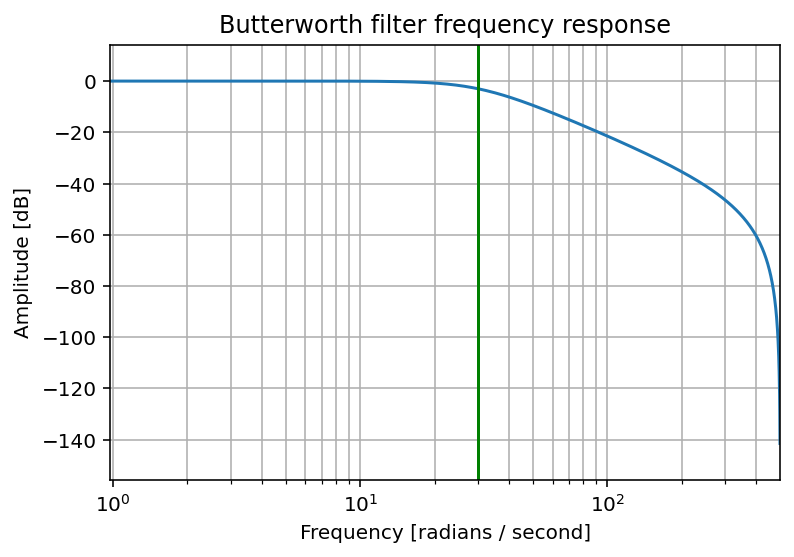

In [5]:
def butter_lowpass(cutoff, fs, order):
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html#scipy.signal.butter
    return butter(order, cutoff, fs=fs, btype='low', analog=False, output='ba')

def butter_lowpass_filter(input_sig, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order=order)
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html?highlight=filtfilt#scipy.signal.filtfilt
    return filtfilt(b, a, input_sig, method="gust") #lfilter(b, a, input_sig)
    
# filter parameters
order = 2 # filter order
fs = 1e3 # sample rate Hz
cutoff = 30 # cutoff frequency Hz

b, a = butter_lowpass(cutoff, fs, order)
w, h = freqz(b, a, fs=fs)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(cutoff, color='green') # cutoff frequency
plt.show()

## Filter data

In [6]:
# new dataframe for filtered data
def filter_data(filename):
    
    # load data from crio and shimmer
    crio_data = load_crio_data(filename+'.lvm')
    shimmer_data = load_shimmer_data(filename+'.txt')
    
    # define column names
    crio_col_nam = ['Top chamber pressure',
                    'Bottom chamber pressure',
                    'Air frame pressure',
                    'Absolute pressure',
                    'Force 1', 'Force 2',
                    'Force 3', 'Force 4']
    
    sh_col_nam = ['ACCL X', 'ACCL Y', 'ACCL Z']

    # new dataframes for filtered data 
    crio_filtered_data = pd.DataFrame(columns = crio_col_nam)
    sh_filtered_data = pd.DataFrame(columns = sh_col_nam)

    # adjust filter parameters
    fs = 1e3 # sample rate Hz
    order = 3 # filter order
    cutoff = [15, 15, 15, 15,
              60, 60, 60, 30,
              120, 120, 120]

    # get number of columns in crio data file
    crio_data_col = np.shape(crio_data)[1]
    
    # parse crio data
    for i in range(crio_data_col):
        crio_filtered_data[crio_col_nam[i]] = butter_lowpass_filter(crio_data.iloc[:, i],
                                                               cutoff[i], fs, order)
    # parse shimmer data
    for i in range(3):
        sh_filtered_data[sh_col_nam[i]] = butter_lowpass_filter(shimmer_data.iloc[:, i+11],
                                                                    cutoff[i+8], fs, order)
    
    return pd.concat([crio_filtered_data, sh_filtered_data],axis=1,sort=False)
    
sample_f_data = filter_data('h3500_m10_vc_1')
sample_f_data #.iloc[:, 8:]

(5000, 10)


,Top chamber pressure,Bottom chamber pressure,Air frame pressure,Absolute pressure,Force 1,Force 2,Force 3,Force 4,ACCL X,ACCL Y,ACCL Z
0,0.059474,0.035240,163.424871,1007.212578,317.704293,61.128748,104.584618,278.548101,-5.871424,-0.252821,8.441248
1,0.060711,0.035527,163.423123,1007.213208,317.706529,61.130687,104.589127,278.861543,-5.861825,-0.245865,8.434922
2,0.062044,0.035838,163.421261,1007.213877,317.710888,61.124460,104.607235,279.236991,-5.849473,-0.230778,8.425810
3,0.063471,0.036173,163.419300,1007.214581,317.717350,61.105874,104.644228,279.671329,-5.839639,-0.209061,8.418068
4,0.064984,0.036530,163.417256,1007.215313,317.725610,61.073037,104.703083,280.156866,-5.838599,-0.187923,8.416899
...,...,...,...,...,...,...,...,...,...,...,...
28053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.920222,8.931443,3.784784
28054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.921188,8.944583,3.784068
28055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.932881,8.956711,3.780819
28056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.948463,8.965375,3.775564


## Plot raw and filtered data

In [7]:
def plot_raw_data(filename):
    # load data
    crio_data = load_crio_data(filename+'.lvm')
    shimmer_data = load_shimmer_data(filename+'.txt')
    filtered_data = filter_data(filename)
    
    col_names = ['Top chamber pressure', 'Bottom chamber pressure', 'Air frame pressure']
    y_labels = ['top chamber\n pressure [mbar]',
                'bottom chamber\n pressure [mbar]',
                'air frame\n pressure [mbar]']
    
    # plot pressure
    fig1, axs1 = plt.subplots(3, 1, figsize=(8,6))
    for i in range(3):
        axs1[i].plot(crio_data[col_names[i]], label='raw')
        axs1[i].plot(filtered_data[col_names[i]], label='filtered')
        axs1[i].legend()
        axs1[i].set_xlim(500, 1500)
        axs1[i].set_xlabel('sample')
        axs1[i].set_ylabel(y_labels[i])
    #axs1[2].set_ylim(160, 200)
    fig1.suptitle('Air pressure', fontsize='x-large')
    fig1.tight_layout()
    plt.show()
    
    # plot forces
    fig2, axs2 = plt.subplots(4, 1, figsize=(8,8))
    for i in range(4):
        axs2[i].plot(crio_data['Force {}'.format(i+1)], label='raw')
        axs2[i].plot(filtered_data['Force {}'.format(i+1)], label = 'filtered')
        axs2[i].set_xlim(500, 1500)
        axs2[i].set_xlabel('sample')
        axs2[i].set_ylabel('Force {} [N]'.format(i+1))
        axs2[i].legend()
    fig2.suptitle('Force', fontsize='x-large')
    fig2.tight_layout()
    plt.show()
    
    # plot acceleration
    fig3, axs3 = plt.subplots(3, 1, figsize=(8,6))
    axis = ['X', 'Y', 'Z']
    for i in range(3):
        axs3[i].plot(shimmer_data['Wide Range Accelerometer {}'.format(axis[i])], label = 'raw')
        axs3[i].plot(filtered_data['ACCL {}'.format(axis[i])], label = 'filtered')
        #axs3[i].set_xlim(13100, 13400)
        axs3[i].set_xlabel('sample')    
        axs3[i].set_ylabel('ACCL {} '.format(axis[i]) + r'$[m/s^2]$')
        axs3[i].legend()
    fig3.suptitle('Accelerations of dumped load', fontsize='x-large')
    fig3.tight_layout()
    plt.show()
    
    pass

## Create iterable object for manual data inspection

In [17]:
data_files = dict(file_names['data_crio'])

# create and fill list of filenames
filenames = []
for i in range(len(data_files)):
    filenames.append((data_files[i].split('.')[0]))

# print(filenames)
filename_iter = iter(filenames)

### Refresh cell below in order to inspect raw experimental data and filtering

h1500_m10_vc_1
(5000, 10)
(5000, 10)


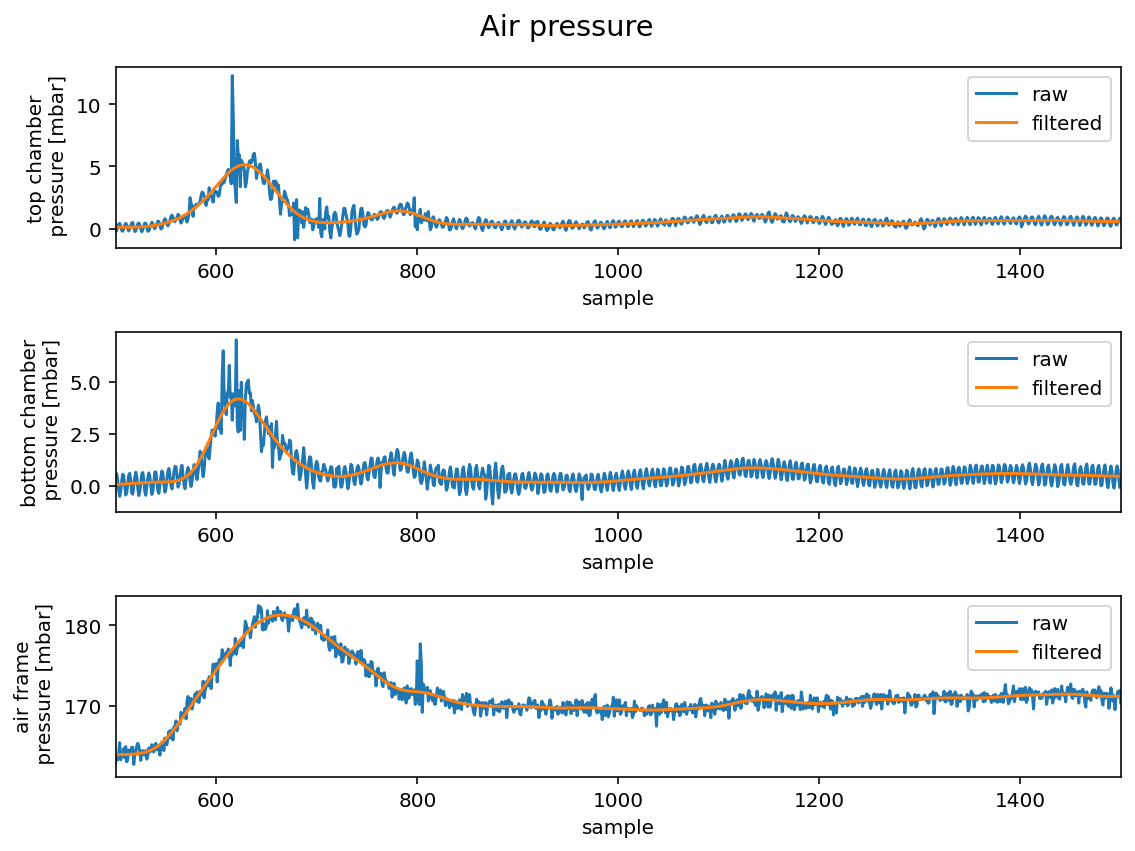

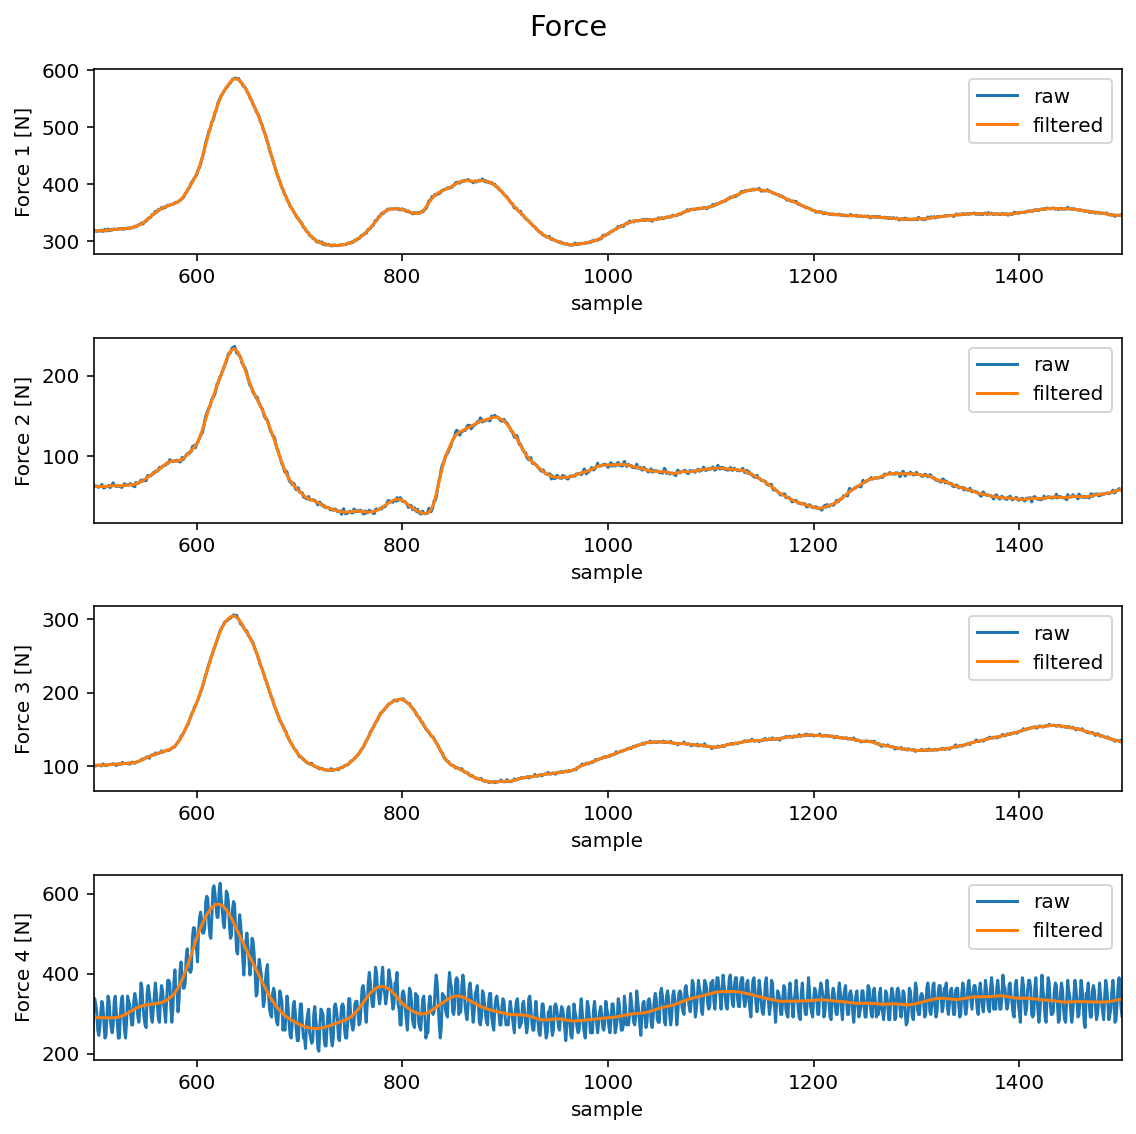

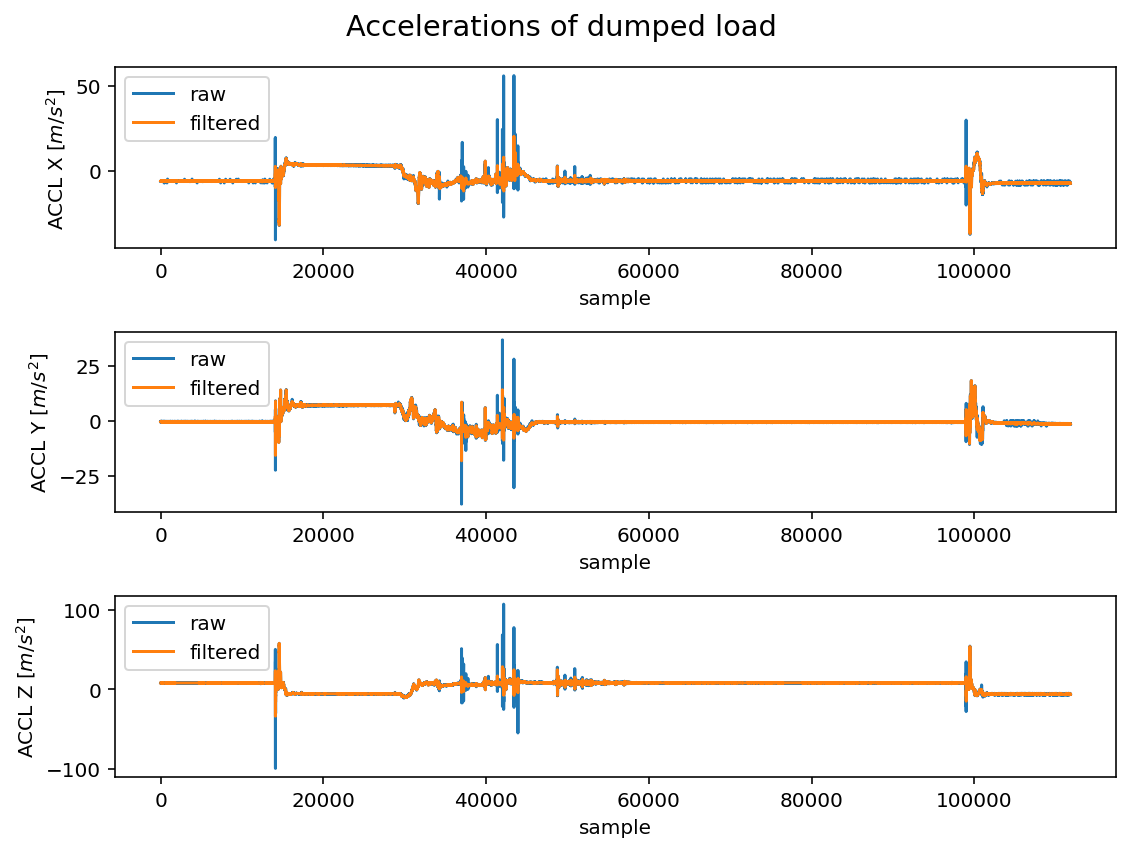

In [9]:
try:
    filename = next(filename_iter)
    print(filename)
    plot_raw_data(filename)
except StopIteration:
    print('No more data to plot!')

## Process experimental data 

In [10]:
# proces and trim signals to required length
def process_exp_dat(filename, req_sig_len = 2000):
    
    # load and filter data 
    filtered_data = filter_data(filename);
    
    # define column names
    col_names = ['Top chamber pressure',
                 'Bottom chamber pressure',
                 'Air frame pressure',
                 'Absolute pressure',
                 'Plate force',
                 'ACCL']
    
    # new data frame 
    processed_data = pd.DataFrame(columns=col_names) 
    processed_data = filtered_data.iloc[:, 0:4]
    
    # list for storing signals temp data
    forces_max_val_index = []
    forces_lag = [] 
    
    for i in range(4):
        # remove static force for each force channel
        force_offset = filtered_data['Force {}'.format(i+1)][50:550].mean()
        filtered_data['Force {}'.format(i+1)] = filtered_data['Force {}'.format(i+1)].subtract(force_offset)
        # find max value in forces vect
        forces_max_val_index.append(np.argmax(filtered_data['Force {}'.format(i+1)]))
        # compute lag for forces 
        forces_lag.append(forces_max_val_index[0]-forces_max_val_index[i])
    
    # print('Max forces indecies: ', forces_max_val_index)
    # print('Forces lag with respect to 1st channel: ', forces_lag)
    
    # remove lag 
    for i in range(len(forces_lag)):
        filtered_data['Force {}'.format(i+1)] = filtered_data['Force {}'.format(i+1)].shift(
            periods = forces_lag[i], axis=0)
    
    # check if lag has been resolved 
    forces_max_val_index = []
    forces_lag = [] 
    for i in range(4):
        # find max value in forces vect
        forces_max_val_index.append(np.argmax(filtered_data['Force {}'.format(i+1)]))
        # compute lag for forces 
        forces_lag.append(forces_max_val_index[0]-forces_max_val_index[i])
    # print('Lag in forces after shift: ', forces_lag)
    
    # sum forces from all channels
    processed_data['Plate force'] = filtered_data.iloc[:, 4:8].sum(axis=1)
    
    # calculate magnitude of a three dimensional acceleration vector 
    processed_data['ACCL'] = np.sqrt(np.sum(np.power(filtered_data.iloc[:, 8:], 2), axis=1))
    
    # remove static offset from acceleration vector
    g = 9.81 # true G value
    accl_offset = processed_data['ACCL'][100:2100].mean() - g
    processed_data['ACCL'] =  processed_data['ACCL'].subtract(accl_offset)
    
    # compute lag between force and acceleration
    plate_accl_lag = np.argmax(processed_data['Plate force']) - np.argmax(processed_data['ACCL'])
    # print('Delay between response of impact plate and wireless accelerometer: ', plate_accl_lag)
    
    # remove lag for wireless accelerometer
    processed_data['ACCL'] = processed_data['ACCL'].shift(periods = plate_accl_lag, axis=0)
    
    # check if lag has been resolved
    plate_accl_lag = np.argmax(processed_data['Plate force']) - np.argmax(processed_data['ACCL'])
    # print('Lag between response of impact plate and wireless accelerometer after shift: ', plate_accl_lag)
    
    # get peak for force and trim data
    force_peak_idx = np.argmax(processed_data['Plate force'])
    processed_data = processed_data[:][force_peak_idx - (req_sig_len // 4) : force_peak_idx + 3*(req_sig_len // 4)]
    
    return processed_data.reset_index(drop = True)

process_exp_dat('h3500_m10_vc_1')

(5000, 10)


,Top chamber pressure,Bottom chamber pressure,Air frame pressure,Absolute pressure,Plate force,ACCL
0,0.103368,0.046642,163.542553,1006.745336,0.195820,-0.031842
1,0.103529,0.045607,163.545184,1006.745401,-0.091950,-0.016859
2,0.103704,0.044582,163.548221,1006.745557,-0.373582,-0.005024
3,0.103893,0.043572,163.551614,1006.745800,-0.649800,-0.003676
4,0.104098,0.042583,163.555303,1006.746124,-0.925308,-0.015163
...,...,...,...,...,...,...
1995,0.507699,0.439016,170.846579,1006.763779,107.511660,9.038366
1996,0.507486,0.438246,170.850808,1006.763857,107.014025,9.073939
1997,0.507302,0.437436,170.854793,1006.763991,106.539689,9.084309
1998,0.507148,0.436590,170.858512,1006.764198,106.097246,9.079942


## Plot processed data

In [11]:
def plot_processed_data(filename):
    
    # load data
    processed_data = process_exp_dat(filename);
    
    col_names = ['Top chamber pressure', 'Bottom chamber pressure', 'Air frame pressure']
    y_labels = ['top chamber\n pressure [mbar]',
                'bottom chamber\n pressure [mbar]',
                'air frame\n pressure [mbar]']
    
    # plot pressure
    fig1, axs1 = plt.subplots(3, 1, figsize=(8,6))
    for i in range(3):
        axs1[i].plot(processed_data[col_names[i]])
        axs1[i].set_xlabel('time [ms]')
        axs1[i].set_ylabel(y_labels[i])
    fig1.suptitle('Air pressure', fontsize='x-large')
    fig1.tight_layout()
    plt.show()
    
    # plot forces and acceleration
    fig2, axs2 = plt.subplots(2, 1, figsize=(8,4))
    axs2[0].plot(processed_data['Plate force'])  
    axs2[0].set_xlabel('time [ms]')
    axs2[0].set_ylabel('plate force [N]')
    axs2[1].plot(processed_data['ACCL'])  
    axs2[1].set_xlabel('time [ms]')
    axs2[1].set_ylabel('ACCL ' + r'$[m/s^2]$')
    fig2.suptitle('Force and accelerations of dumped load', fontsize='x-large')
    fig2.tight_layout()
    plt.show()
    
    pass

### Refresh cell below in order to inspect processed experimental data

h1500_m10_vc_2
(5000, 10)


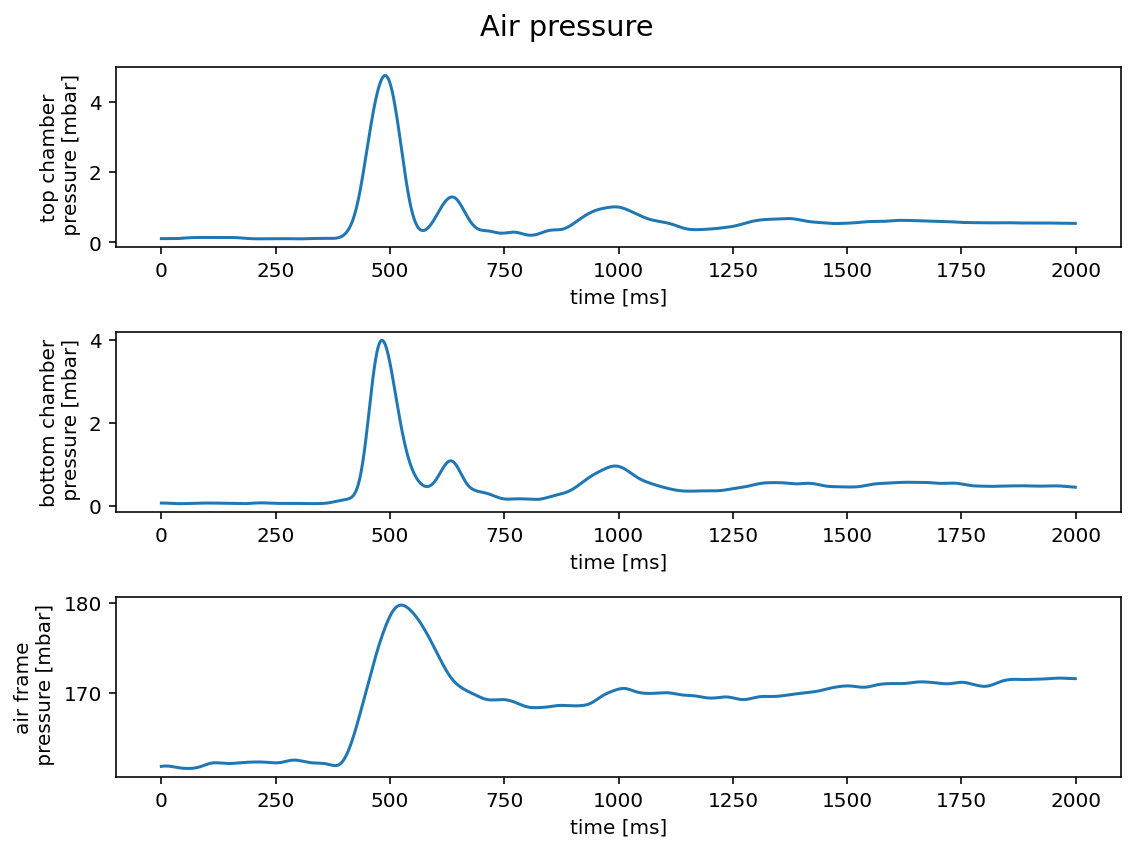

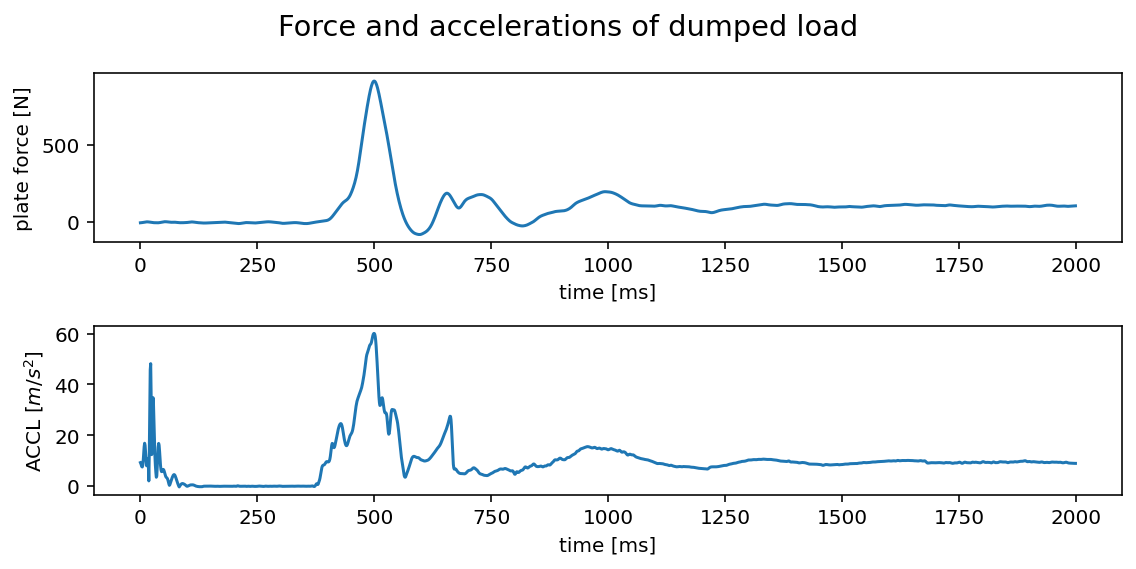

In [12]:
try:
    filename = next(filename_iter)
    print(filename)
    plot_processed_data(filename)
except StopIteration:
    print('No more data to plot!')

## Save processed data to CSV

In [13]:
# set path for output data
output_dir_name = 'output'
output_data_dir = path.join(data_dir, output_dir_name)
output_dir_exists = path.exists(output_data_dir)

# check if default directory exist otherwise create new one 
if not output_dir_exists:
    print("No file in a directory creeating new file: '{}'" .format(output_dir_name))
    mkdir(output_data_dir)

# save CSV files
for name in filenames:
    #print(name)
    temp = process_exp_dat(name)
    temp.to_csv(path.join(output_data_dir, '{}.csv'.format(name)))

print('All done!')

(5000, 10)
(5000, 10)
(5000, 10)
(5000, 10)
(5000, 10)
(5000, 10)
(5000, 10)
(5000, 10)
(5000, 10)
(5000, 10)
(5000, 10)
(5000, 10)
(5000, 10)
(5000, 10)
(5000, 10)
(5000, 10)
(5000, 10)
(5000, 10)
(5000, 10)
(5000, 10)
(5000, 10)
(5000, 10)
(5000, 10)
(5000, 10)
All done!


## Compare experimental data

In [22]:
def plot_exp_data_comp(filelist):
        
    # load data
    # processed_data = process_exp_dat(filename);

    y_labels = ['top chamber\n pressure [mbar]',
                'bottom chamber\n pressure [mbar]',
                'air frame\n pressure [mbar]']

    # subplot for pressure
    fig1, axs1 = plt.subplots(3, 1, figsize=(8,6))
    
    # description of axes
    for i in range(3):
        axs1[i].set_xlabel('time [ms]')
        axs1[i].set_ylabel(y_labels[i])
        
    # description of chart
    fig1.suptitle('Air pressure', fontsize='x-large')
    fig1.tight_layout()
    plt.show()
        
    # subplot forces and acceleration
    fig2, axs2 = plt.subplots(2, 1, figsize=(8,4))
    
    # description of axes
    axs2[0].set_xlabel('time [ms]')
    axs2[0].set_ylabel('plate force [N]')
    axs2[1].set_xlabel('time [ms]')
    axs2[1].set_ylabel('ACCL ' + r'$[m/s^2]$')
    
    # description of chart
    fig2.suptitle('Force and accelerations of dumped load', fontsize='x-large')
    fig2.tight_layout()
    plt.show()
    
    for filename in filelist:
        test_description = filename.split('_')
        print(test_description)
    # axs2[0].plot(processed_data['Plate force'])
    # axs2[1].plot(processed_data['ACCL'])  
    
    pass

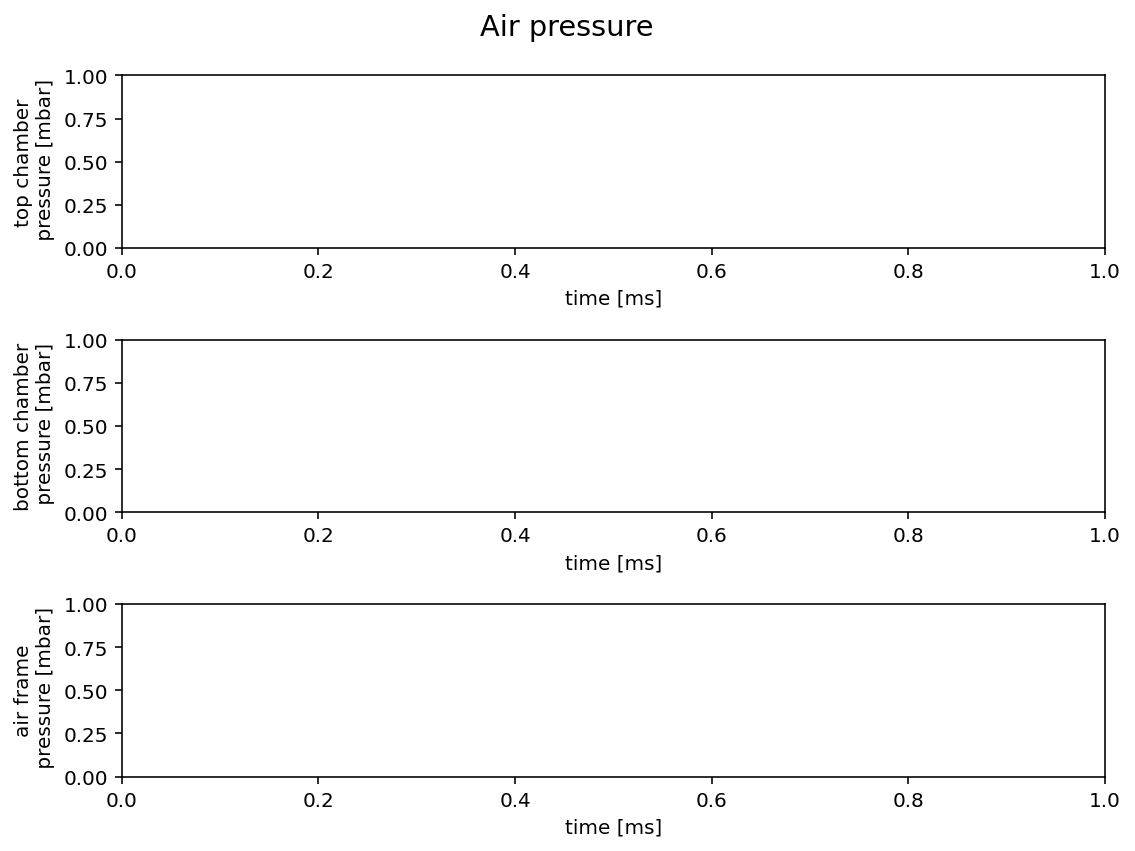

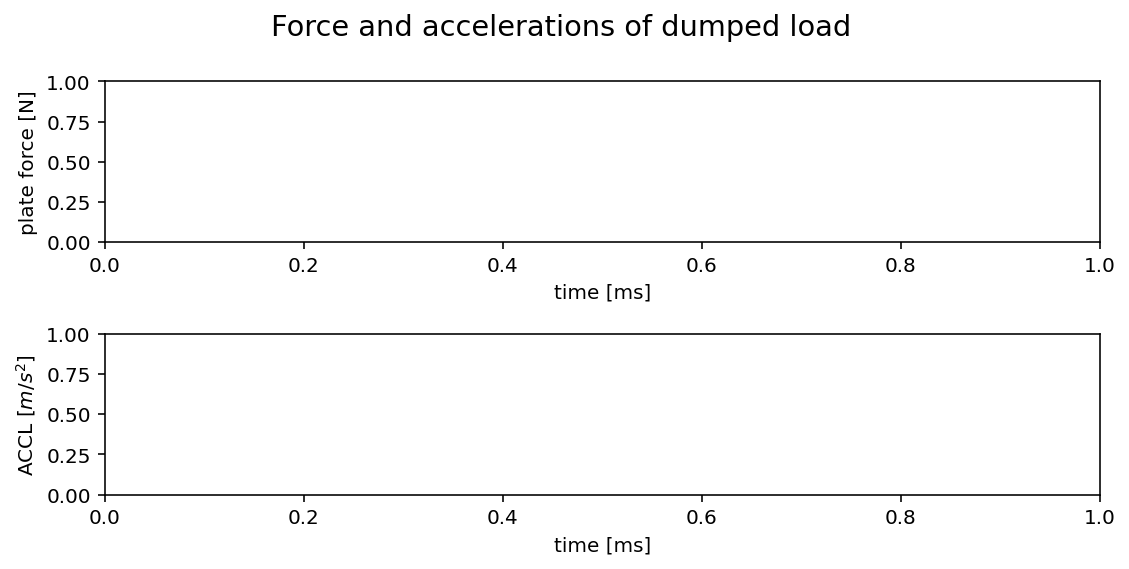

['h1500', 'm10', 'vc', '1']
['h1500', 'm10', 'vc', '2']
['h1500', 'm10', 'vo', '1']
['h1500', 'm10', 'vo', '2']
['h1500', 'm5', 'vc', '1']
['h1500', 'm5', 'vc', '2']
['h1500', 'm5', 'vo', '1']
['h1500', 'm5', 'vo', '2']
['h2500', 'm10', 'vc', '1']
['h2500', 'm10', 'vc', '2']
['h2500', 'm10', 'vo', '1']
['h2500', 'm10', 'vo', '2']
['h2500', 'm5', 'vc', '1']
['h2500', 'm5', 'vc', '2']
['h2500', 'm5', 'vo', '1']
['h2500', 'm5', 'vo', '2']
['h3500', 'm10', 'vc', '1']
['h3500', 'm10', 'vc', '2']
['h3500', 'm10', 'vo', '1']
['h3500', 'm10', 'vo', '2']
['h3500', 'm5', 'vc', '1']
['h3500', 'm5', 'vc', '2']
['h3500', 'm5', 'vo', '1']
['h3500', 'm5', 'vo', '2']


In [23]:
# set data range for experiment to plot
#h = [1500, 2500, 3500] # height
#m = [5, 10] # mass
#valve_state = ['vo', 'vc']
#test_no = [1, 2]

plot_exp_data_comp(filenames)

## Movie

In [ ]:
# play movie
movie_title = file_names['data_movies'][16]
movie_path = path.join(data_dir, 'movies', movie_title)
Video(movie_path, width=600, height=480)

In [ ]:
# 1. ta sama wysokość 
# 1. różne masy
# 1. otwarty zamknięty